Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/datasets/autos.csv")
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


**Признаки:**  
* DateCrawled — дата скачивания анкеты из базы  
* VehicleType — тип автомобильного кузова  
* RegistrationYear — год регистрации автомобиля  
* Gearbox — тип коробки передач  
* Power — мощность (л. с.)  
* Model — модель автомобиля  
* Kilometer — пробег (км)  
* RegistrationMonth — месяц регистрации автомобиля  
* FuelType — тип топлива  
* Brand — марка автомобиля  
* NotRepaired — была машина в ремонте или нет  
* DateCreated — дата создания анкеты  
* NumberOfPictures — количество фотографий автомобиля  
* PostalCode — почтовый индекс владельца анкеты (пользователя)  
* LastSeen — дата последней активности пользователя  

**Целевой признак:**  
* Price — цена (евро)  

In [3]:
df.shape

(354369, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
print("**Пропуски**")
df.isna().sum() # na's

**Пропуски**


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
print("Кол-во марок автомобилей:", len(df["Brand"].unique()))
print("Кол-во моделей автомобилей:", len(df["Model"].unique()))
print("Кузов автомобиля:", len(df["VehicleType"].unique()))
print("Средний пробег: {:.0f}".format(df["Kilometer"].mean()))

Кол-во марок автомобилей: 40
Кол-во моделей автомобилей: 251
Кузов автомобиля: 9
Средний пробег: 128211


In [7]:
df = df.drop(["PostalCode", "LastSeen", "RegistrationMonth", "RegistrationYear"], axis=1) # Drop not informative columns

# to datetime round to day

df["DateCrawled"] = pd.to_datetime(df["DateCrawled"]).dt.round("D")
df["DateCreated"] = pd.to_datetime(df["DateCreated"]).dt.round("D")

In [9]:
# Find the difference
difference = (df["DateCrawled"] - df["DateCreated"])

difference.value_counts()[:5]

1 days    276475
0 days     75390
2 days      1083
3 days       479
7 days        81
dtype: int64

> Большинство данных были собраны в тот же или на следующий день после выставки на продажу. Поэтому сохранять оба столбца не имеет смысла - удалим `DateCrawled`

In [10]:
df.drop("DateCrawled", axis=1, inplace=True)

> Много пропущенных значений в столбце `VehicleType`, пользователи часто не заполняли эту строку. Эти данные можно достать исходя из модели автомобиля.

In [11]:
# dictionary where 
# keys - model
# values - vehicleType
models_vehType = df.groupby("Model")['VehicleType'].agg(lambda x:x.value_counts().index[0]).to_dict()

def vehicle_type_inputer(row):
    """takes row and returns vehicle type
    depending on Model
    """
    
    model = row["Model"]
    veh_Type = row["VehicleType"]
    
    if model == "NG" and veh_Type == "NG":
        return "NG"
    elif model == "NG" and veh_Type != "NG":
        return veh_Type
    
    return models_vehType[model]

# fill na's with "NG"
df["Model"] = df["Model"].fillna("NG")
df["VehicleType"] = df["VehicleType"].fillna("NG")

df["VehicleType"] = df[["VehicleType", "Model"]].apply(vehicle_type_inputer, axis=1)

In [12]:
df[df["VehicleType"]=="NG"]["VehicleType"].count() # Проверим

6828

> Избавились от 30000 пропусков

In [13]:
df["NotRepaired"].fillna("yes", inplace=True) # Если NotRepaired пропущено, считаем, что продавец имеет ввиду отсутствие ремонта

df.dropna(inplace=True) # Оставшиеся пропущенные значения удалим

df.isna().sum().sum() # check

### Добавим столбец день недели, месяц и год создания объвления

In [16]:
df["weekday"] = df["DateCreated"].dt.weekday
df["month"] = df["DateCreated"].dt.month
df["year"] = df["DateCreated"].dt.year

df.drop('DateCreated', axis=1, inplace=True)

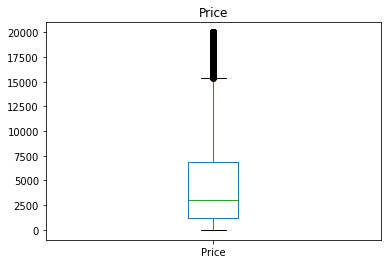

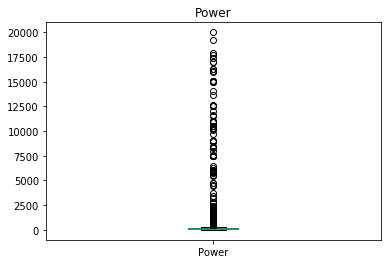

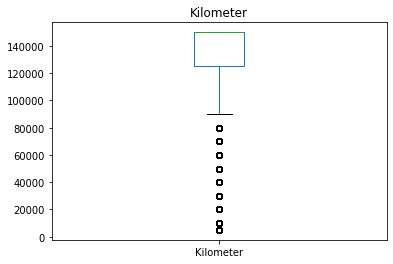

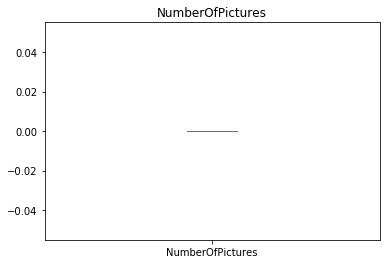

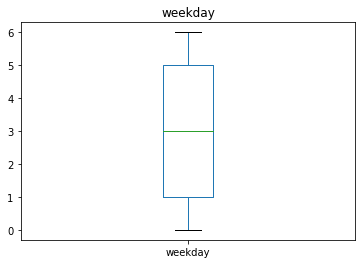

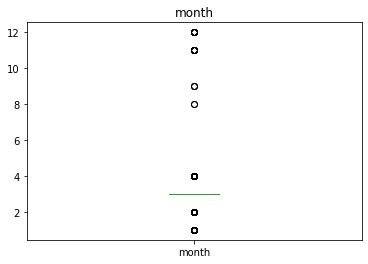

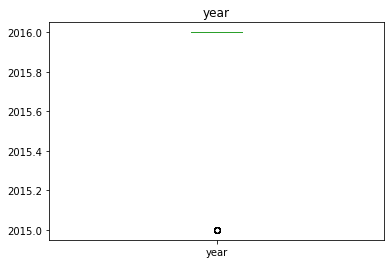

In [18]:
numerical = df.select_dtypes(include='number')

for col in numerical:
    df[col].plot.box()
    plt.title(col)
    plt.show()

# 2. Обучение моделей

In [19]:
categorical = df.select_dtypes(include='object').columns.to_list() + ['weekday', 'month', 'year'] # list of categorical columns

print("**Categorical columns**")
print()
print(", ".join(categorical))

**Categorical columns**

VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired, weekday, month, year


In [20]:
mse = mean_squared_error

In [21]:
label_encoder = LabelEncoder()

for col in categorical:
    df[col] = label_encoder.fit_transform(df[col])

In [22]:
# split data
X_with_cat = df.drop("Price", axis=1)
y = df["Price"]

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_with_cat, y, test_size=0.2, random_state=421)

#### CatBoost

```python
%%time
best_rmse = 10**6
kf = KFold(n_splits=3, shuffle=True, random_state=241)
params_cat = {
              "depth" : [i for i in range(10, 16, 5)]
             }

cat = CatBoostRegressor(iterations=300, cat_features=categorical,  verbose=50)
grid_cat = GridSearchCV(estimator=cat, param_grid=params_cat, cv=kf, n_jobs=-1)
grid_cat.fit(X_train_cat, y_train_cat)

print(mse(y_test_cat, grid_cat.best_estimator_.predict(X_test_cat))**(.5))
```

In [23]:
%%time
cat = CatBoostRegressor(iterations=500, depth=10, cat_features=categorical, verbose=100)
cat.fit(X_train_cat, y_train_cat)

0:	learn: 4522.3550329	total: 1.85s	remaining: 15m 22s
100:	learn: 2604.0440981	total: 2m 37s	remaining: 10m 22s
200:	learn: 2477.5418774	total: 5m 21s	remaining: 7m 58s
300:	learn: 2410.3136867	total: 8m 9s	remaining: 5m 23s
400:	learn: 2356.3937929	total: 11m 1s	remaining: 2m 43s
499:	learn: 2312.7946643	total: 13m 48s	remaining: 0us
CPU times: user 13min 4s, sys: 45.7 s, total: 13min 50s
Wall time: 13min 53s


In [24]:
%%time
cat_pred = cat.predict(X_test_cat)

CPU times: user 771 ms, sys: 57.9 ms, total: 829 ms
Wall time: 824 ms


In [25]:
print("RMSE на тесте: ", mse(y_test_cat, cat_pred)**(.5))

RMSE на тесте:  2358.944013923634


### LightGBM

```python
%%time
params_lgbm = {
               #"max_depth" : [i for i in range(10, 16, 5)]
              }
lgbm = LGBMRegressor(categorical_feature=categorical)
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=params_lgbm, cv=kf, n_jobs=-1)
grid_lgbm.fit(X_train_cat, y_train_cat)

print("RMSE на тесте: ", mse(y_test_cat, grid_lgbm.best_estimator.predict(X_test_cat))**(.5))



# Dead kernel
lgbm = LGBMRegressor(iterations=100, categorical_feature=categorical, silent=True)
lgbm.fit(X_train_cat, y_train_cat)

print(mse(y_test, lgbm.predict(X_test))**(.5))
```

### One-hot-encoding

```python
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[categorical]))

# One-hot encoding removed index; put it back
OH_cols.index = df.index

# Remove categorical columns (will replace with one-hot encoding)
num_X = df.drop(categorical, axis=1)

# Add one-hot encoded columns to numerical features
OH_df = pd.concat([num_X, OH_cols], axis=1)
```

In [26]:
OH_df = pd.get_dummies(df, columns=categorical, drop_first=True)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_with_cat, y, test_size=0.2, random_state=421)

### Linear

In [28]:
%%time

lr = LinearRegression(normalize=True)

lr.fit(X_train, y_train)

CPU times: user 110 ms, sys: 30.8 ms, total: 141 ms
Wall time: 98.7 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [29]:
%%time
lr_pred = lr.predict(X_test)

CPU times: user 7.71 ms, sys: 8.91 ms, total: 16.6 ms
Wall time: 4.59 ms


In [30]:
mse(y_test, lr_pred)**(.5)

3650.189473142458

### Lasso

In [31]:
%%time

lasso = Lasso(normalize=True)

lasso.fit(X_train, y_train)

CPU times: user 87.7 ms, sys: 32.4 ms, total: 120 ms
Wall time: 91.4 ms


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [32]:
%%time
lasso_pred = lasso.predict(X_test)

CPU times: user 25.3 ms, sys: 40.6 ms, total: 65.9 ms
Wall time: 94.6 ms


In [33]:
mse(y_test, lasso_pred)**(.5)

3817.5559520026254

### Ridge

In [34]:
%%time

ridge = Ridge(normalize=True)

ridge.fit(X_train, y_train)

CPU times: user 56.5 ms, sys: 21.2 ms, total: 77.7 ms
Wall time: 120 ms


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [35]:
%%time
ridge_pred = ridge.predict(X_test)

CPU times: user 18.5 ms, sys: 34.5 ms, total: 53 ms
Wall time: 64.7 ms


In [36]:
mse(y_test, ridge_pred)**(.5)

3877.3697797903883

# 3. Анализ моделей

In [39]:
#      time rmse  
data = [["14 min", "824 ms", 2360],
        ["-", "-", "-"],
        ["0.145 s.", "84.8 ms", 3650],
        ["0.192 s.", "99.2 ms", 3817],
        ["0.106 s.", "66.8 ms", 3870]]
model = ["Catboost", "LGBM", "Linear", "Lasso", "Ridge"]

In [40]:
pd.DataFrame(data=data, index=model, columns=["fit_time", "predict_time", "RMSE"])

,fit_time,predict_time,RMSE
Catboost,14 min,824 ms,2360
LGBM,-,-,-
Linear,0.145 s.,84.8 ms,3650
Lasso,0.192 s.,99.2 ms,3817
Ridge,0.106 s.,66.8 ms,3870


>#### Наилучшим качеством обладает модель Catboost, время обучения составило 14 минут, а время предсказания 824 милисекунд. В то же время линейная регрессия с RMSE на 35% хуже, предсказывает в 10 раз быстрее.